In [1]:
import torch
import torch.optim as optim
import numpy as np
from datetime import datetime
import random
import os
import shutil

# import own modules
# ----------------------------------------------------------------------------
import plot_functions as pf
import torch_functions as tofu
import market_functions as mf
from util import timediff_d_h_m_s
from data_creator import data_creator
from agents import simple_agent
import FinMa

import importlib
import sys
import pickle

importlib.reload(sys.modules["FinMa"])
importlib.reload(FinMa)
importlib.reload(pf)
importlib.reload(mf)
importlib.reload(tofu)
importlib.reload(sys.modules['data_creator'])


from FinMa import FinMa, BSassets
from data_creator import data_creator

In [2]:
import config_1.config as config

mp = config.MARKET_PARAMS
dhp = config.DH_PARAMS
dhtp = config.DH_TRAIN_PARAMS
seed = config.SEED

if config.EVAL_PARAMS['use_wandb']:
    import wandb
    wandb.init(project=f"PPO_DH_{config.CONFIG_NO}", config={'seed':seed}, reinit=True)
    wandb.config.update(dhp)
    wandb.config.update(dhtp)
    wandb.config.update(mp)


In [3]:
# 1. Set `python` pseudo-random generator at a fixed value
random.seed(seed)

# 2. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 3. Set 'torch' pseudo-random generator at a fixed value
torch.manual_seed(seed)

### 1. Market environment

In [4]:
interest = mp["interest"]
npath = dhp["npath"]
ntime = mp["ntime"]
x0 = mp["x0"]
gamma = np.exp(-interest / ntime)

d = mp["d"]
s0 = mp["s0"]
mu = mp["mu"]
sig = mp["sig"]
cor = mp["cor"]
stds = np.sqrt(sig * np.eye(d))
Sigma = (stds @ cor @ stds).tolist()  # covariance structure of BM


additional_states = None
num_states = d + 2 

# additional states besides time, asset and portfolio value
if 'additional_states' in mp.keys():
    if mp['additional_states'] is not None:
        additional_states = mp['additional_states']
        l = len(additional_states)
        if 'signX' in additional_states:
            num_states += 1
            l -= 1
        num_states += l*d



deep_hedging=True

In [5]:
if config.SAVE["model"]:
    if deep_hedging:
        foldername = os.path.join(
        f"config_{config.CONFIG_NO}",
        f"DH_" + datetime.now().strftime("%d-%m-%Y_%H:%M") + "/",
    )
    else:
        foldername = os.path.join(
            f"config_{config.CONFIG_NO}",
            f"PG_" + datetime.now().strftime("%d-%m-%Y_%H:%M") + "/",
        )
    path = os.path.join(
        os.getcwd(),
        foldername,
    )
    os.makedirs(path)
    
    datapath = os.path.join(
        os.getcwd(),
        f"config_{config.CONFIG_NO}",
    )
    configpath = os.path.join(
        datapath,
        'config.py',
    )
    shutil.copyfile(configpath, os.path.join(path,'config.py'))
elif config.SAVE["plots"] and config.SAVE["plot_path"] is None:
    print("Error: Please supply path to save plots in config file.")
    exit()

### 2. Set up Strategy NN

In [6]:
# initiate strategy

num_outputs = d
model = []

for t in range(ntime):
    model.append(tofu.DH_Net(num_states, num_outputs))

In [7]:
# --------------------------------------------------------------------
# set parameters
# --------------------------------------------------------------------
epochs = dhtp["epochs"]
batch_size = dhtp["batch_size"]

opt = optim.Adam(model[0].parameters(), dhtp["lr"],
 weight_decay=dhtp["l2"])
for i in range(1,ntime):
    opt.add_param_group({'params': model[i].parameters()}) 

weights = dhp[
    "weights"
]  # how to weigh positive part and absolute value in MC estimate?

entropy_reg = None
if 'entropy_reg' in dhtp.keys():
    entropy_reg = dhtp['entropy_reg']

#### 2.1. Plot Initialized Strategy NN

In [8]:
asset = BSassets(
    interest=interest, s0=s0, sigma=Sigma, mu=mu, dim=d, ntime=ntime, npath=1
)
market = FinMa(
    pv0=x0,
    ntime=ntime,
    interest=interest,
    dim=d,
    npath=1,
    asset_model=asset,
    additional_states=additional_states
)

In [9]:
if d < 3:
    # create test paths
    npath2plot = 1000

    x0path = np.expand_dims(np.repeat(x0, npath2plot), axis=1)

    # create new market data or load standard data set
    W, S2plot = mf.create_paths(
        filepath="",
        npath=npath2plot,
        ntime=ntime,
        Sigma=Sigma,
        mu=mu,
        r=interest,
        s0=np.ones((npath2plot, d)),
        retBM=True,
        save_paths=False,
    )


In [10]:
if d<3:
    # determine approximated strategy (samples from NN-probability for the prediction)
    q, p = mf.strategies(
        npath=npath2plot,
        ntime=ntime,
        d=d,
        model=model,
        S=S2plot,
        r=interest,
        poss_action=market.poss_action,
        hardmax=True,
        x0path=x0path,
        market_env=market,
    )

    print("finished predicting strategy\n")

    # portfolio value when trading with fitted strategy
    pv = mf.portfolio_value(
        q,
        S2plot,
        interest,
        x0path,
    )

finished predicting strategy



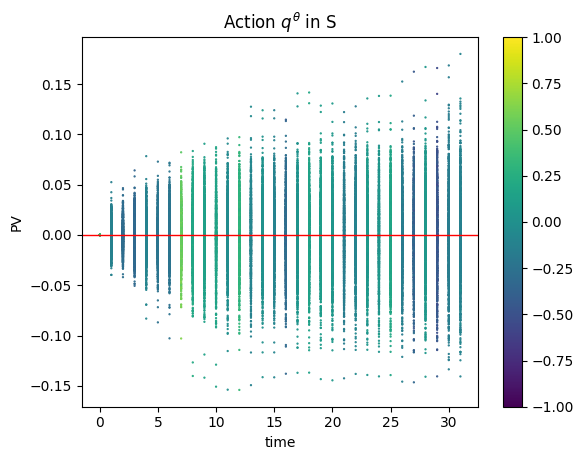

In [11]:
if d < 3:
    # Probability plots

    x = S2plot[:, :, 0]  # x-axis (however if timescale==True, x-axis will be time)
    timescale = True
    y = pv  # y-axis

    strat = q
    omegas = range(0, npath2plot, 2 ** 0)  # paths to plot

    pf.plot_probabilities(
        d=d,
        timerange=ntime,
        omegas=omegas,
        y=y,
        strategy_process=strat,
        poss_action=market.poss_action,
        x=x,
        timescale=timescale,
        xlabel="S",  # will be overwritten if timescale==True
        ylabel="PV",
        connectpaths=False,
        save=config.SAVE["plots"],
        name=foldername,
        relaxed=False,
    )  # set to true if paths should be connected by lines

### 3. Initiate Market

In [12]:
asset_env = BSassets(
    interest=interest,
    s0=s0,
    sigma=Sigma,
    mu=mu,
    dim=d,
    ntime=ntime,
    npath=batch_size,
)
market_env = FinMa(
    pv0=x0,
    ntime=ntime,
    interest=interest,
    dim=d,
    npath=batch_size,
    asset_model=asset_env,
    additional_states=additional_states,
)

### 4. Training

In [13]:
episode_len = ntime
total_reward = []


In [14]:
start = datetime.now()
logging_dict = {}

for num_iter in range(epochs*(npath//batch_size)):

    
    # at each iteration, we roll out an episode using current policy until it reach termination state
    reward = []
    log_pi = []
    critics = []
    add_task_preds = []
    add_task_targets = []

    market_env.reset()
    s = market_env.state
    PV = torch.tensor(market_env.pv)    
    for t in range(episode_len):
        # given current state, the actor outputs action
        state = torch.tensor(s, dtype=torch.float)        
        action = model[t](state)
        action.retain_grad()

        
        (s, r, is_terminal,) = market_env.step(
            action.detach().numpy().reshape((batch_size, 1, d)),
            log_type=2,
            keep_env_pathdim=True,
        )
        reward.append(r)
        
        # calculate expected payoff
        stock_gain = torch.sum(
            torch.multiply(torch.tensor(market_env.stock.ret),action.reshape((batch_size, 1, d))),
            dim=-1,
            keepdims=True,
        )
        int_gain = (
            market_env.interest
            * (
                PV
                - torch.sum(
                    torch.multiply(torch.tensor(market_env.stock.state), action.reshape((batch_size, 1, d))),
                    dim=-1,
                    keepdims=True,
                )
            )
            / market_env.ntime
        )

        PV += stock_gain + int_gain

        # the loop is never broken for the PPO with terminal payoff only. however it might be needed for different payoff structures
        if is_terminal:
            break
    # append state at T+1
    state = torch.tensor(s, dtype=torch.float)
    
    # store total_reward
    discounted_rew = [reward[i] * gamma ** i for i in range(len(reward))]
    total_reward.append(np.mean(sum(discounted_rew)))

    actor_loss = -market_env.calc_reward(terminal_value=PV, weights=weights)

    logging_dict['actor_loss'] = actor_loss
    logging_dict['total_reward'] = total_reward[-1]

    if num_iter>500:
        logging_dict['running average reward 500']= np.mean(total_reward[-500:])
    
    actor_loss.retain_grad() # in case one wants to log the gradient
    opt.zero_grad()
    actor_loss.backward()
    opt.step()


    if (num_iter//epochs) % 100 == 0:
        total_loss, current = actor_loss.item(), (num_iter//epochs) * npath
        
        if config.EVAL_PARAMS['use_wandb']:
            wandb.log({'actor_loss': actor_loss,})
        to_print = f"[{current:>5d}/{batch_size:>5d}] total_loss: {total_loss:>7f}"

    if config.EVAL_PARAMS['use_wandb']:
        wandb.log(logging_dict)

# take time after training
end = datetime.now()
print(
    "\nTraining Time: {}d {}h:{}m:{}s".format(*timediff_d_h_m_s(end - start)),
    "(" + datetime.now().strftime("%H:%M %d-%m-%Y") + ")",
)


Training Time: 0d 0h:4m:59s (11:54 01-02-2023)


In [15]:
if config.SAVE["model"]:
    for i in range(ntime):
        torch.save(model[i].state_dict(), path + f"model_{i}")

### 5. Testing and visualizing

In [16]:
save = config.SAVE["plots"]

### Trade with Trained Agent

In [17]:
if d<3: # determine approximated strategy (samples from NN-probability for the prediction)
    q, p = mf.strategies(
        npath=npath2plot,
        ntime=ntime,
        d=d,
        model=model,
        S=S2plot,
        r=interest,
        poss_action=market.poss_action,
        hardmax=True,
        x0path=x0path,
        market_env=market,
    )

    print("finished predicting strategy\n")

    # portfolio value when trading with fitted strategy
    pv = mf.portfolio_value(
        q,
        S2plot,
        interest,
        x0path,
    )

finished predicting strategy



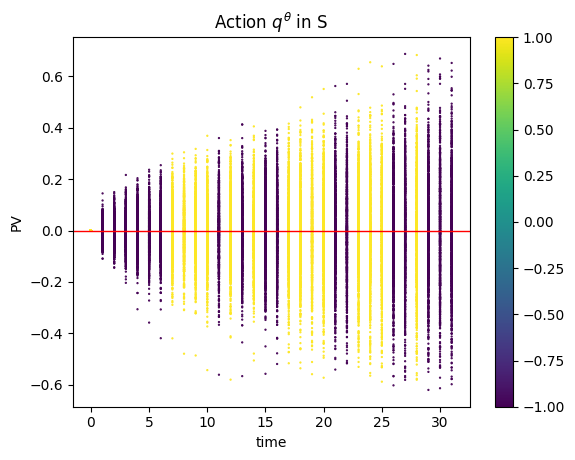

In [18]:
if d < 3:
    # Probability plots

    x = S2plot[:, :, 0]  # x-axis (however if timescale==True, x-axis will be time)
    timescale = True
    y = pv  # y-axis

    strat = q
    omegas = range(0, npath2plot, 2 ** 0)  # paths to plot

    pf.plot_probabilities(
        d=d,
        timerange=ntime,
        omegas=omegas,
        y=y,
        strategy_process=strat,
        poss_action=market.poss_action,
        x=x,
        timescale=timescale,
        xlabel="S",  # will be overwritten if timescale==True
        ylabel="PV",
        connectpaths=False,
        save=True,
        name=foldername,
        relaxed=False,
    )  # set to true if paths should be connected by lines